In [2]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

import matplotlib.pyplot as plt

import seaborn as sns

### Encoding

In [3]:
data = pd.read_csv("/Users/alexisbarrett/301/project/madmax/cleaned_dataset/19062018_dataset_cleaned_first_attempt.csv")

In [4]:
data.summary

AttributeError: 'DataFrame' object has no attribute 'summary'

In [3]:
def recode_diag(diag_input):
    try:
        diag = diag_input
        print(diag)
        rules_1 = [diag >= 390 and diag <= 459,diag == 785]
        rules_2 = [diag >= 460 and diag <= 519,diag == 786]
        rules_3 = [diag >= 520 and diag <= 579, diag == 787]
        rules_4 = [diag > 250 and diag < 251]
        rules_5 = [diag >= 800 and diag <= 999]
        rules_6 = [diag >= 710 and diag <= 793]
        rules_7 = [diag >= 580 and diag<= 629, diag == 788]
        rules_8 = [diag >= 140 and diag <= 239, diag == 780, diag == 781, diag == 784, diag >= 790 and diag <= 799,
        diag >= 240 and diag <= 279, diag != 250, diag >= 680 and diag <= 709, diag == 782, diag >= 1 and diag <= 139]
        rules_9 = [diag >= 290 and diag <= 319, diag >= 289 and diag <= 289, diag >= 320 and diag <= 359, diag >= 630 and diag <= 679,
        diag >= 360 and diag <= 389, diag >= 740 and diag <= 759]
        if all(rules_1):
            diag_1_new = 1
        elif all(rules_2):
            diag_1_new = 2
        elif all(rules_3):
            diag_1_new = 3
        elif all(rules_4):
            diag_1_new = 4
        elif all(rules_5):
            diag_1_new = 5
        elif all(rules_6):
            diag_1_new = 6
        elif all(rules_7):
            diag_1_new = 7
        elif all(rules_8):
            diag_1_new = 8
        elif all(rules_9):
            diag_1_new = 9
        else:
            diag_1_new = 9
        return diag_1_new
    except:
            return diag_input

In [4]:
df = data.copy()
# create a duplicate of the diagnosis column
df['level1_diag1'] = df['diag_1']
# disease codes starting with V or E are in “other” category; so recode them to 0
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1']] = 0
# also replace the unknown values with -1
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level1_diag1'] = pd.to_numeric(df['level1_diag1'])
# iterate and recode disease codes between certain ranges to certain categories
for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0
# convert this variable to float type to enable computations later
df['level1_diag1'] = df['level1_diag1'].astype(float)

In [5]:
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)

In [6]:
df = df.drop(['citoglipton', 'examide'], axis = 1)

In [7]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

In [8]:
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

In [9]:
age_dict = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55, '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}
df['age'] = df.age.map(age_dict)
df['age'] = df['age'].astype('int64')

In [10]:
df['gender'] = df['gender'].replace('?', -1)

In [11]:
race_dict = {'Caucasian':1, 'AfricanAmerican':2, 'Hispanic':3, '?':-1, 'Asian':4, 'Other' : 5}
df['race'] = df['race'].map(race_dict)

In [12]:
df['race'] = df['race'].astype('int64')

In [13]:
df['gender'] = df['gender'].replace('Unknown/Invalid',-1)

In [14]:
df = df.drop(['Unnamed: 0'],axis=1)

In [15]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    df[col] = df[col].replace("Steady", 1)
    df[col] = df[col].replace("Down", 1)
    df[col] = df[col].replace("Up", 1)
    df[col] = df[col].replace("No", 0)

### Save/Load Clean Dataset

In [17]:
df.to_csv("20062018_cleanest_dataset_v2.csv", sep=',', index=False)

In [2]:
df = pd.read_csv("20062018_cleanest_dataset_v2.csv", sep=',')

### Define input-target sets

In [3]:
feature = ["race","gender","age", "admission_type_id", "discharge_disposition_id", 'chlorpropamide','tolazamide', 'metformin-pioglitazone','glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'miglitol', 'insulin', 'glyburide-metformin','glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose','glimepiride', 'glipizide',"nateglinide","repaglinide","number_inpatient", "admission_source_id", "time_in_hospital", "change", "A1Cresult", "number_diagnoses", "diabetesMed",'metformin', "num_procedures", "num_medications", "number_outpatient", "number_emergency"]
X = df[feature].values
y = df[["readmitted"]].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Model DT

In [6]:
clf = DecisionTreeClassifier(max_depth = 3)

clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [28]:
# save the model to disk
filename = '/Users/alexisbarrett/301/project/madmax/python_project/madmax_dtree.sav'
pickle.dump(clf, open(filename, 'wb'))

In [5]:
# load the model from disk
filename = '/Users/alexisbarrett/301/project/madmax/python_project/madmax_dtree.sav'
clf = pickle.load(open(filename, 'rb'))

### Eval DT

In [12]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))
print(classification_report(y_test,pred))

[[20984    16]
 [ 2092     5]]
0.9087327358531411
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21000
           1       0.24      0.00      0.00      2097

    accuracy                           0.91     23097
   macro avg       0.57      0.50      0.48     23097
weighted avg       0.85      0.91      0.87     23097



In [7]:
feature_names = feature
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(5, "Importance")
print(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(19, 5))
plt.rc('xtick',labelsize=25)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8, color='yellow')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=25)
plt.title("Kurscheidt's Decision Tree Most Important Features", fontsize=32)
plt.savefig('./images/RFfeatImportance.jpg')
# plt.show()

                     Feature  Importance
4   discharge_disposition_id    0.522412
25          number_inpatient    0.477588
0                       race    0.000000
1                     gender    0.000000
2                        age    0.000000


NameError: name 'plt' is not defined

Text(0.5, 1, 'XGBoost\n ACC: 90.87%\n F1: 86.62%')

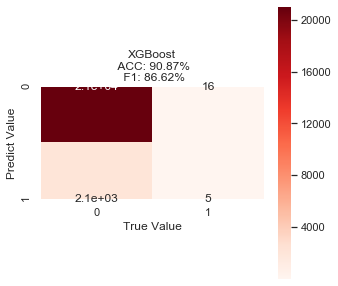

In [7]:
# Save confusion matrix figure
pred = clf.predict(X_test)
mat = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
plt.figure(figsize=(5, 5))
sns.set(font_scale=1)
sns.heatmap(mat, square=True, annot=True, cmap='Reds')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.title('XGBoost\n ACC: {0:.2f}%\n F1: {1:.2f}%'.format(acc * 100, f1 * 100))
#plt.savefig('./images/randomForest.png')

### Fancy Tree

In [8]:
from sklearn import tree
from dtreeviz.trees import *

viz = dtreeviz(clf, 
               X_train, 
               y_train.T[0],
               target_name='30-Day Readmission',
              feature_names=feature, 
               class_names=["No Readmission","<30 Readmission"]  # need class_names for classifier
              )  
              
viz.view()

### Simple Tree

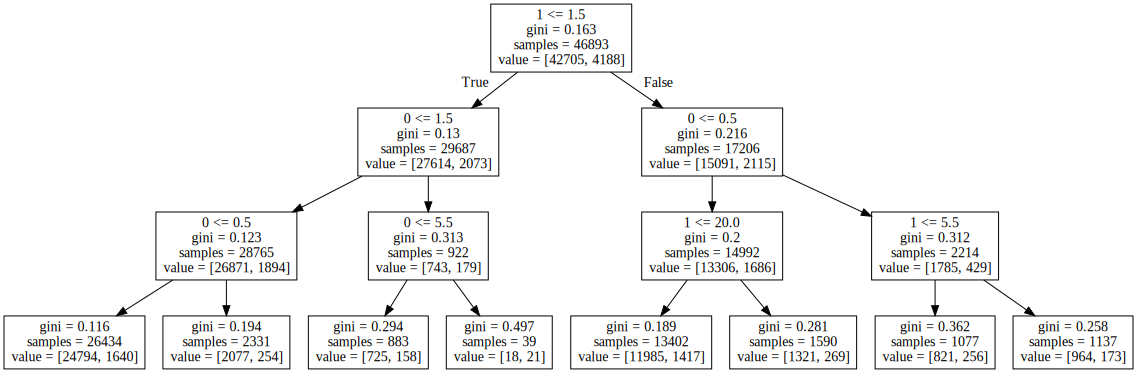

In [29]:
from sklearn import tree 
from graphviz import Source
from IPython.display import SVG

tree.export_graphviz(clf) 
graph = Source( tree.export_graphviz(clf, out_file=None, feature_names=X[0]))
SVG(graph.pipe(format='svg'))

### RF Classifier

In [13]:
rfc = RandomForestClassifier(n_estimators=30,n_jobs=-1)

rfc = rfc.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
# save the model to disk
filename = '/Users/alexisbarrett/301/project/madmax/python_project/madmax_rforest.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [9]:
# load the model from disk
filename = '/Users/alexisbarrett/301/project/madmax/python_project/madmax_rforest.sav'
rfc = pickle.load(open(filename, 'rb'))

### Eval RF

In [33]:
pred_rfc = rfc.predict(X_test)
print(confusion_matrix(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))
print(classification_report(y_test,pred_rfc))

[[20984    16]
 [ 2092     5]]
0.9087327358531411
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21000
           1       0.24      0.00      0.00      2097

    accuracy                           0.91     23097
   macro avg       0.57      0.50      0.48     23097
weighted avg       0.85      0.91      0.87     23097



In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

scoring=['precision','recall']
scores = cross_validate(rfc, X, y, scoring=scoring, cv=5, return_train_score=False)
print(scores)
print(scores["test_recall"].mean())
print(scores["test_precision"].mean())

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'fit_time': array([0.11037588, 0.09191489, 0.09450388, 0.09394002, 0.09073496]), 'score_time': array([0.00842595, 0.00768924, 0.00811481, 0.00745225, 0.00805211]), 'test_precision': array([0., 0., 0., 0., 0.]), 'test_recall': array([0., 0., 0., 0., 0.])}
0.0
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
feature_names = feature
feature_imports = rfc.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names, feature_imports)],
                                 columns=["Feature", "Importance"]).nlargest(5, "Importance")
print(most_imp_features)
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(19, 5))
plt.rc('xtick',labelsize=25)
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8, color='yellow')
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance', fontsize=25)
plt.title("Kurscheidt's Decision Tree Most Important Features", fontsize=32)
plt.savefig('./images/RFfeatImportance.jpg')
# plt.show()

                     Feature  Importance
4   discharge_disposition_id    0.522412
25          number_inpatient    0.477588
0                       race    0.000000
1                     gender    0.000000
2                        age    0.000000


NameError: name 'plt' is not defined

### Fancy Tree Random Forest

In [15]:
viz = dtreeviz(rfc, 
               X_train, 
               y_train.T[0],
               target_name='30-Day Readmission',
               feature_names=feature, 
               class_names=["No Readmission","<30 Readmission"]  # need class_names for classifier
              )  
              
viz.view()

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

### PyDotPlus RF Visualization

/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


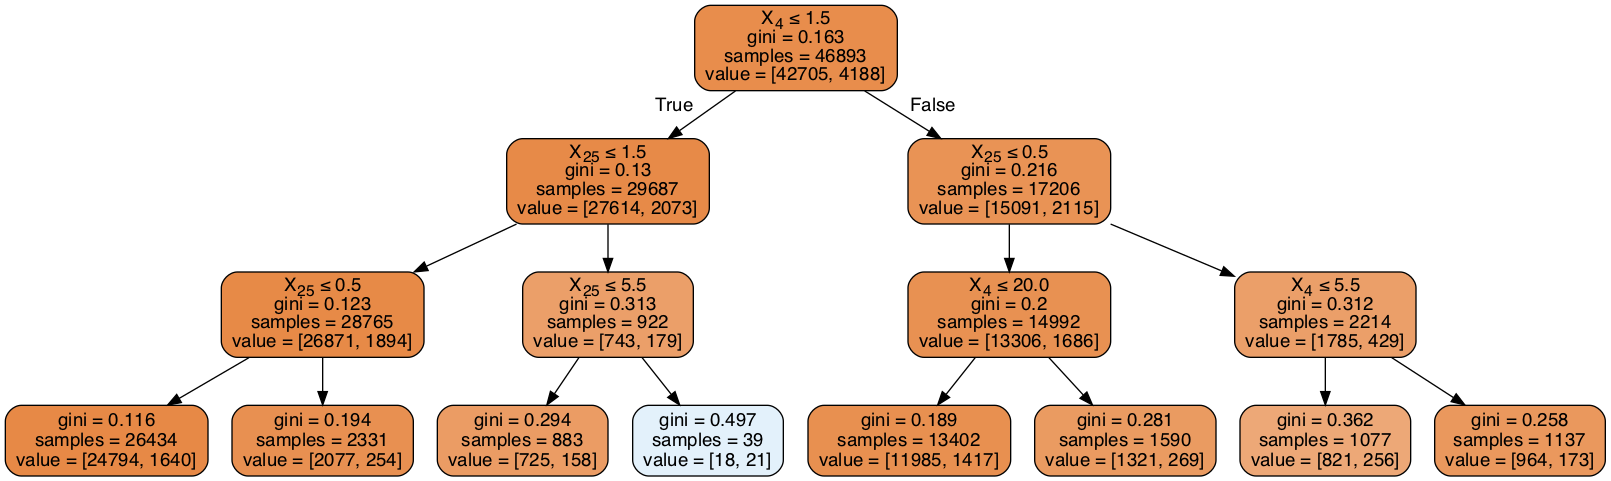

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(rfc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())